In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import time
import cv2

import torch.cuda
import torch.nn as nn
import torchvision.models as models
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import datasets, transforms

#from pytorch_model_summary import summary
import os

In [2]:
#seed everything
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [3]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [5]:
data_dir = "/scratch/zl4917/3001/Final/tumor/Training"

The shape of the images in the dataset is (512, 512, 3).
Here is an example of an image in the dataset:


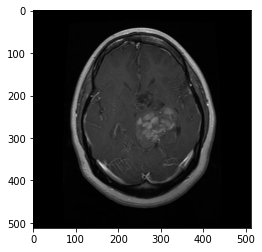

In [6]:
image = plt.imread("/scratch/zl4917/3001/Final/tumor/Training/glioma_tumor/gg (1).jpg")
print(f"The shape of the images in the dataset is {image.shape}.")
print("Here is an example of an image in the dataset:")
plt.imshow(image)

In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 8 
NUM_WORKERS = 2

In [8]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(           #This normalization is applied as it is the same applied to the images in ImageNet
            mean=[0.485, 0.456, 0.406], #and we'll be using Trasnfer Learning (for example EfficientNetB0)
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

In [9]:
dataset = datasets.ImageFolder(data_dir, transform=(get_train_transform(IMAGE_SIZE)))
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_dataset, val_dataset = random_split(dataset, lengths)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=NUM_WORKERS, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)

In [10]:
dataset.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [11]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, "/scratch/zl4917/3001/Final")
    
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("/scratch/zl4917/3001/Final")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("/scratch/zl4917/3001/Final")    

In [12]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        return x


def build_model(pretrained=True, fine_tune=True, num_classes=4):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.resnet50(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    #model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    # Add a projection head to the model.
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model.projection_head = ProjectionHead(2048, 2048, 128)
    return model

In [13]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [14]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [17]:
args = {'learning_rate' : 0.0001, 'epochs' : 50}
dataset_classes = dataset.class_to_idx

In [18]:
lr = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
model = build_model(
    pretrained=True,
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(2)

# Save the trained model weights.
#save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
#save_plots(train_acc, valid_acc, train_loss, valid_loss)
show_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 50

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
30,015,656 total parameters.
30,015,656 training parameters.
[INFO]: Epoch 1 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.62it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.90it/s]


Training loss: 1.135, training acc: 78.354
Validation loss: 0.328, validation acc: 89.199
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.61it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.07it/s]


Training loss: 0.275, training acc: 90.070
Validation loss: 0.279, validation acc: 90.767
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.48it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.86it/s]


Training loss: 0.204, training acc: 93.206
Validation loss: 0.242, validation acc: 91.463
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.59it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.96it/s]


Training loss: 0.159, training acc: 94.904
Validation loss: 0.200, validation acc: 93.902
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.56it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.04it/s]


Training loss: 0.102, training acc: 96.298
Validation loss: 0.161, validation acc: 94.599
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.55it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.81it/s]


Training loss: 0.127, training acc: 95.862
Validation loss: 0.182, validation acc: 94.599
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.67it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.87it/s]


Training loss: 0.113, training acc: 96.646
Validation loss: 0.130, validation acc: 95.993
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.51it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.85it/s]


Training loss: 0.057, training acc: 98.040
Validation loss: 0.170, validation acc: 94.251
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.71it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.76it/s]


Training loss: 0.077, training acc: 97.605
Validation loss: 0.176, validation acc: 94.948
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.57it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.15it/s]


Training loss: 0.080, training acc: 97.648
Validation loss: 0.246, validation acc: 92.509
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.51it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.13it/s]


Training loss: 0.070, training acc: 97.779
Validation loss: 0.105, validation acc: 96.167
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.51it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.87it/s]


Training loss: 0.066, training acc: 97.822
Validation loss: 0.110, validation acc: 97.213
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.67it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.89it/s]


Training loss: 0.040, training acc: 98.693
Validation loss: 0.129, validation acc: 95.993
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.80it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.88it/s]


Training loss: 0.080, training acc: 97.213
Validation loss: 0.277, validation acc: 91.986
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.62it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.86it/s]


Training loss: 0.059, training acc: 97.866
Validation loss: 0.202, validation acc: 93.728
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.59it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.62it/s]


Training loss: 0.050, training acc: 98.606
Validation loss: 0.176, validation acc: 94.948
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.91it/s]


Training loss: 0.041, training acc: 98.563
Validation loss: 0.214, validation acc: 94.251
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.58it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.03it/s]


Training loss: 0.036, training acc: 98.868
Validation loss: 0.094, validation acc: 96.864
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.83it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.83it/s]


Training loss: 0.044, training acc: 98.868
Validation loss: 0.162, validation acc: 94.948
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.63it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.04it/s]


Training loss: 0.066, training acc: 97.561
Validation loss: 0.145, validation acc: 95.296
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.61it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.00it/s]


Training loss: 0.051, training acc: 98.432
Validation loss: 0.139, validation acc: 95.819
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.52it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.58it/s]


Training loss: 0.039, training acc: 98.606
Validation loss: 0.109, validation acc: 97.038
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.56it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.75it/s]


Training loss: 0.025, training acc: 99.172
Validation loss: 0.150, validation acc: 95.122
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.84it/s]


Training loss: 0.050, training acc: 98.084
Validation loss: 0.112, validation acc: 96.516
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.77it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.50it/s]


Training loss: 0.047, training acc: 98.519
Validation loss: 0.314, validation acc: 89.024
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.75it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.05it/s]


Training loss: 0.052, training acc: 98.084
Validation loss: 0.142, validation acc: 95.645
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.65it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.58it/s]


Training loss: 0.041, training acc: 98.737
Validation loss: 0.133, validation acc: 95.819
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.73it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.94it/s]


Training loss: 0.039, training acc: 98.432
Validation loss: 0.147, validation acc: 96.167
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.59it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.00it/s]


Training loss: 0.051, training acc: 98.258
Validation loss: 0.163, validation acc: 95.296
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.11it/s]


Training loss: 0.029, training acc: 99.042
Validation loss: 0.129, validation acc: 97.213
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.73it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.01it/s]


Training loss: 0.046, training acc: 98.606
Validation loss: 0.240, validation acc: 93.206
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.52it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.12it/s]


Training loss: 0.037, training acc: 98.737
Validation loss: 0.077, validation acc: 97.038
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.51it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.57it/s]


Training loss: 0.033, training acc: 99.129
Validation loss: 0.084, validation acc: 97.038
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.70it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.83it/s]


Training loss: 0.020, training acc: 99.303
Validation loss: 0.146, validation acc: 95.819
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.80it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.74it/s]


Training loss: 0.032, training acc: 98.998
Validation loss: 0.099, validation acc: 97.387
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.83it/s]


Training loss: 0.018, training acc: 99.434
Validation loss: 0.139, validation acc: 95.993
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.57it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.79it/s]


Training loss: 0.033, training acc: 99.085
Validation loss: 0.206, validation acc: 95.645
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.71it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.69it/s]


Training loss: 0.042, training acc: 98.476
Validation loss: 0.281, validation acc: 90.418
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.82it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.92it/s]


Training loss: 0.064, training acc: 97.822
Validation loss: 0.088, validation acc: 96.516
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.58it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.99it/s]


Training loss: 0.028, training acc: 99.042
Validation loss: 0.126, validation acc: 95.645
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.63it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.90it/s]


Training loss: 0.033, training acc: 99.260
Validation loss: 0.265, validation acc: 93.031
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.50it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.89it/s]


Training loss: 0.023, training acc: 99.260
Validation loss: 0.121, validation acc: 97.387
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.72it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.74it/s]


Training loss: 0.013, training acc: 99.652
Validation loss: 0.135, validation acc: 96.167
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.52it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.82it/s]


Training loss: 0.008, training acc: 99.869
Validation loss: 0.180, validation acc: 95.470
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.06it/s]


Training loss: 0.012, training acc: 99.652
Validation loss: 0.091, validation acc: 97.038
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 144/144 [00:14<00:00,  9.69it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.61it/s]


Training loss: 0.007, training acc: 99.782
Validation loss: 0.148, validation acc: 95.645
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.48it/s]


Training loss: 0.017, training acc: 99.477
Validation loss: 0.092, validation acc: 96.516
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]

Validation



100%|██████████| 36/36 [00:03<00:00, 10.38it/s]


Training loss: 0.038, training acc: 98.780
Validation loss: 0.130, validation acc: 95.993
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.75it/s]


Training loss: 0.033, training acc: 98.911
Validation loss: 0.105, validation acc: 96.516
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]

Validation



100%|██████████| 36/36 [00:03<00:00,  9.89it/s]


Training loss: 0.021, training acc: 99.390
Validation loss: 0.169, validation acc: 95.296
--------------------------------------------------


NameError: name 'show_plots' is not defined

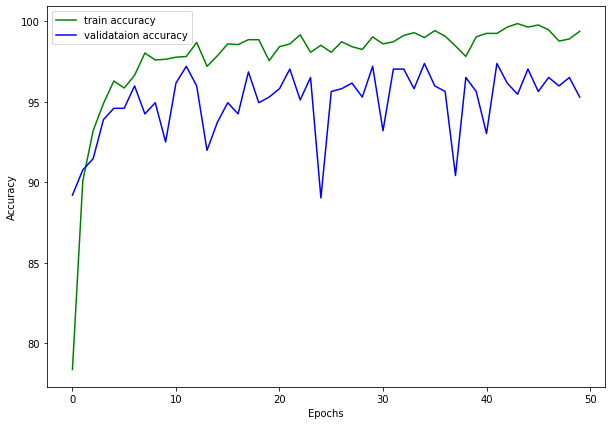

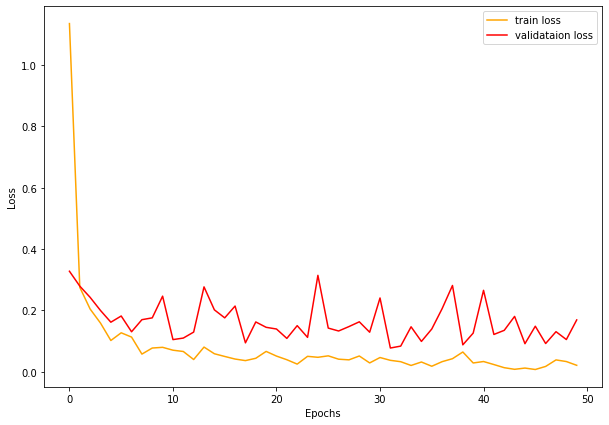

In [20]:
show_plots(train_acc, valid_acc, train_loss, valid_loss)

In [22]:
test_data_dir = "/scratch/zl4917/3001/Final/tumor/Testing"
test_dataset = datasets.ImageFolder(test_data_dir, transform=get_train_transform(IMAGE_SIZE))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)
#model = loaded_model()
# 5. Perform inference on the test dataset and calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test dataset: {100 * correct / total:.2f}%")

Accuracy of the model on the test dataset: 76.14%


In [19]:
def show_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig("/scratch/zl4917/3001/Final")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [42]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [44]:
criterion

CrossEntropyLoss()